In [21]:
from models.LeNet import LeNet
from matplotlib import pyplot as plt
import torch

In [22]:
lenet = LeNet()

Model weights loaded successfully


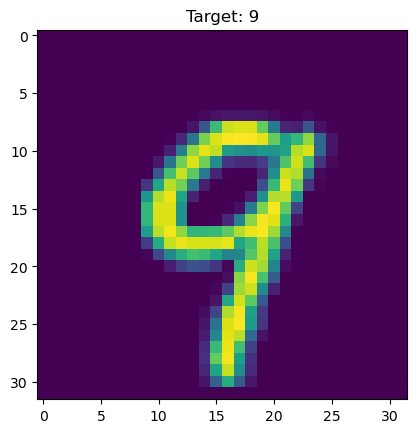

In [75]:
ex_num = 12
x0, y = lenet.test_dataset[ex_num]
x0_np = x0.squeeze()
plt.imshow(x0_np)
plt.title(f"Target: {y}")
plt.show()

In [33]:

lenet.optimizer.zero_grad()
input_tensor = x0.view(1, 1, 32, 32)
input_tensor.requires_grad_()
outputs = lenet.model(input)
loss = lenet.cost(outputs, torch.tensor([y]).to(lenet.device))
    
# Backward and optimize
lenet.optimizer.zero_grad()
loss.backward()
input_tensor.grad

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming LeNet is defined as per your previous structure
from models.LeNet import LeNet

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_classes = 10
learning_rate = 0.001

# Initialize the model
model = lenet.model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare the input tensor
input_tensor = x0.view(1, 1, 32, 32).to(device)
input_tensor.requires_grad_()

# Zero the gradients
optimizer.zero_grad()

# Forward pass
outputs = model(input_tensor)
loss = criterion(outputs, torch.tensor([y]).to(device))

# Backward pass to compute the gradients
loss.backward()
input_gradient = input_tensor.grad

print(input_gradient)
torch.norm(input_gradient)

tensor([[[[ 1.2259e-07,  1.5092e-07,  1.2914e-07,  ..., -4.7472e-09,
           -1.0465e-08,  0.0000e+00],
          [ 6.6821e-08,  1.3236e-07, -2.6092e-08,  ...,  2.7290e-09,
           -1.1225e-08,  0.0000e+00],
          [-3.0564e-07, -4.7386e-07, -2.3172e-06,  ...,  6.2466e-07,
            1.0746e-06,  0.0000e+00],
          ...,
          [ 3.7814e-08,  6.8624e-09,  7.6115e-08,  ...,  1.0918e-06,
            4.0120e-07,  0.0000e+00],
          [ 7.1740e-08,  5.6028e-08,  1.9645e-07,  ..., -9.7012e-07,
            6.7897e-07,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00]]]])


tensor(0.0002)

In [58]:
torch.norm(input_gradient)

tensor(0.0976)